This notebook contains all the simulation codes to regenerate the results in the paper:

S. Dev, S. Manandhar, F. Yuan, Y. H. Lee and S. Winkler, Cloud Radiative Effect Study Using Sky Camera, Proc. IEEE AP-S Symposium on Antennas and Propagation and USNC-URSI Radio Science Meeting, 2017.

### Input all the necessary libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
import sys
sys.path.insert(0, './helperFunctions/')


# User defined functions
from undistortImg import *
from color16mask import *
from nearest import *
from make_cluster_mask import *
from import_WS_CI import *

### Read a sample image and display it

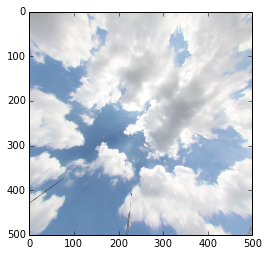

In [2]:
image_loc = './input/2016-03-10-12-16-04-wahrsis3.jpg'

im = cv2.imread(image_loc)
unImage = undistortCC(im)
plt.figure(1)
plt.imshow(unImage[:,:,[2,1,0]])
plt.savefig('./results/undisImage.pdf', format='pdf')

Coverage of the image is  0.71106 [The values are in the range [0,1]]


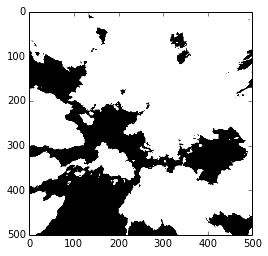

In [3]:
im = unImage
(rows,cols,_)=im.shape
im_mask = np.ones((rows,cols))
(inp_mat) = colorc15mask(im,im_mask)
(th_image,coverage) = make_cluster_mask_default(inp_mat,im_mask)
print ('Coverage of the image is ',coverage, '[The values are in the range [0,1]]')

plt.figure(2)
plt.imshow(th_image, cmap = cm.bone)
plt.savefig('./results/binaryImage.pdf', format='pdf')

### Read the weather station data

In [4]:
CSV_file = './input/radiosonde_Mar2016.csv'

(daterange,datetime_range,solar_range,clearsky_range,clearnessindex_range,rainfall_range) = import_WS_CI(CSV_file)

### Find the unique dates

In [5]:
unik_dates = list(set(daterange))
unik_dates = sorted(unik_dates)

The coverage data of all the days in month of March 2016 are calculated seperately. The results are stored in individual text files in the folder './results/coverageFiles'

### Concatenate all the coverage info in a single text file

In [6]:
import os
from glob import glob
from shutil import copyfile

# delete only if file exists ##
baseFile = './input/coverageFiles/newfile.txt'
if os.path.exists(baseFile):
    print ('Removed previous version')
    os.remove(baseFile)
else:
    print("Sorry, I can not remove %s file." % baseFile)

txt_files = []

# Change this path to your desired directory.
start_dir = './input/coverageFiles/' 

# Check for all .txt files if any.
pattern  = "*.txt"
for direc,_,_ in os.walk(start_dir):
    txt_files.extend(glob(os.path.join(direc,pattern)))  

firstFile = txt_files[0]
outfile = open("./input/coverageFiles/newfile.txt", "w")

# Copy first file
with open(firstFile, "r") as ins:
    for _,line in enumerate(ins):
        outfile.write(line)

for fname in txt_files[1:]:
    with open(fname, "r") as ins:
        for i,line in enumerate(ins):
            if (i>0): # Only non-header lines
                outfile.write(line)
                
outfile.close()              

    

Removed previous version


### Read the concatenated text file.

In [7]:
CI_file = './input/coverageFiles/newfile.txt'

with open(CI_file) as f: #f is a file header 
    reader = csv.reader(f, delimiter=",")
    d = list(reader) # d is a list of list here.
    

# Time and Cloud Coverage data from images
image_time = []
image_CV = []

for item in d[1:]:
    date_string = item[1]
    date_components = date_string.split(":")
    YY = int(date_components[0])
    MM = int(date_components[1])
    DD = int(date_components[2])
    
    time_string = item[2]
    time_components = time_string.split(":")
    HH = int(time_components[0])
    MINT = int(time_components[1])
    SEC = int(time_components[2])
    
    sw = datetime.datetime(YY,MM,DD,HH,MINT,SEC)
    image_time.append(sw)
    
    CI_data = item[3]
    image_CV.append(CI_data) 
    

    
# image_CV and image_time contain the Cloud Coverage and Time information of images

### Extract common time stamps between clearness index and cloud coverage 

In [8]:
WS_timestamp = datetime_range
image_timestamp = image_time

WS_index = clearnessindex_range
solar_array = solar_range
clearSky_array = clearsky_range

# Final extracted data points
common_timestamps = []
WS_datapoints = []
img_datapoints = []
solarRad_datapoints = []
clearSky_datapoints = []


# Check wrt to image datapoints.
for i,check_time in enumerate(image_timestamp):
    
    (time_found,diff_ts) = nearest(check_time,WS_timestamp)
    #print ('Check time is ',check_time,'and found time is ',time_found, 'Difference = ' , diff_ts)
    
    # If difference is less than 10 seconds
    if np.abs(diff_ts)<10:
        
        common_timestamps.append(check_time)
        img_datapoints.append(image_CV[i])
        
        # Check the corresponding index of WS data
        i2 = WS_timestamp.index(time_found)
        WS_datapoints.append(WS_index[i2])
        
        solarRad_datapoints.append(solar_array[i2])
        clearSky_datapoints.append(clearSky_array[i2])



# Extracting info from list
WS_dtp = np.zeros(len(WS_datapoints))
for i,qaz in enumerate(WS_datapoints):
    WS_dtp[i] = float(qaz)
    

# Extracting info from list
img_dtp = np.zeros(len(img_datapoints))
for i,qaz in enumerate(img_datapoints):
    img_dtp[i] = float(qaz)
    
    
# Extracting info from list
solar_dtp = np.zeros(len(solarRad_datapoints))
for i,qaz in enumerate(solarRad_datapoints):
    solar_dtp[i] = float(qaz)    
    
    
# Extracting info from list
clearSky_dtp = np.zeros(len(clearSky_datapoints))
for i,qaz in enumerate(clearSky_datapoints):
    clearSky_dtp[i] = float(qaz)     
    


### Result

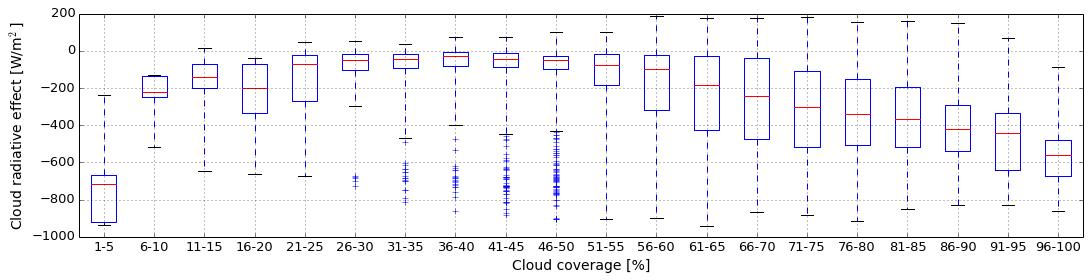

In [9]:
CRE_dtp = solar_dtp - clearSky_dtp


# I want to create 25 bins for cloud coverage. Each bin 4 %
NO_OF_BINS = 20   # Just note that 100/NO_OF_BINS should be an integer number
coverage_array = 100*img_dtp
CRE_array = CRE_dtp
clearness_array = WS_dtp

box_coverage = [[] for _ in range(NO_OF_BINS)]

for i,item in enumerate(coverage_array):
    whichBin = int(item/(100/NO_OF_BINS))
    if whichBin==NO_OF_BINS:
        whichBin = NO_OF_BINS - 1
    box_coverage[whichBin].append(CRE_array[i])

    
labelList = []
for ll in np.arange(1,1+NO_OF_BINS):
    labelList.append(str(int((100/NO_OF_BINS)*(ll-1)+1)) + '-' + str(int((100/NO_OF_BINS)*ll)))   
    

fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(111)
plt.boxplot(box_coverage,whis=5)
ax.set_xticklabels(labelList)
ax.set_xlabel('Cloud coverage [%]', fontsize=14)
ax.set_ylabel(r'Cloud radiative effect [W/m$^2$]', fontsize=14) 
ax.grid(True)
ax.tick_params(labelsize=13)
plt.savefig('./results/boxPlot.pdf', format='pdf')
plt.show()


### Calculate the percentage of data points which are less than 5%

In [10]:
x = coverage_array
non_zero_arr = np.extract(x<5,x)

pre_value = (len(non_zero_arr)/len(x))*100

print ('The percentage of values is: ', pre_value)

The percentage of values is:  0.17282010997643363


### Illustration of solar radiation for a single day

2016-03-02


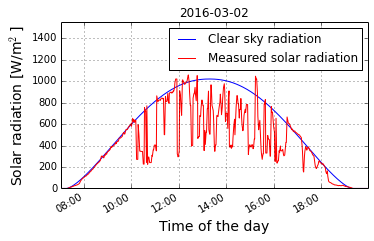

In [11]:
oneFineDate = unik_dates[1]
print (oneFineDate)

findPosition = np.where( np.array(daterange) == oneFineDate )
findPosition = findPosition[0]
    
day_datetime = list( datetime_range[i] for i in findPosition )
day_clearnessindex = list( clearnessindex_range[i] for i in findPosition )
day_rain = list( rainfall_range[i] for i in findPosition )
day_solarrad = list( solar_range[i] for i in findPosition )    
day_CSR = list( clearsky_range[i] for i in findPosition )
    
# Difference solar radiation
day_diffindex = [1-x for x in day_clearnessindex]

match_string = str(oneFineDate)

start_time = datetime.datetime(2016,3,2,7,0,0)
end_time = datetime.datetime(2016,3,2,20,0,0)

measSolar = []
csSolar = []
timeXAxis = []
for i,item in enumerate(day_datetime):
    if item > start_time and item<end_time:
        measSolar.append(day_solarrad[i])
        csSolar.append(day_CSR[i])
        sw = datetime.datetime(item.year,item.month,item.day,item.hour,item.minute,item.second)
        timeXAxis.append(sw)
        
measSolar = np.array(measSolar)
csSolar = np.array(csSolar)
        
    
figure_number = 1 
fig = plt.figure(figure_number , figsize=(5.5, 3.3))
plt.plot(timeXAxis, csSolar, 'b' , label='Clear sky radiation') 
plt.plot(timeXAxis, measSolar, 'r' , label='Measured solar radiation') 
plt.xlabel('Time of the day', fontsize=14)
plt.ylabel(r'Solar radiation [W/m$^2$]', fontsize=14)  
plt.title(match_string)
plt.legend(loc='upper right')
plt.grid(b=None, which='major', axis='both')
plt.ylim((0,1550))
fig.autofmt_xdate()
formatter = DateFormatter('%H:%M')
plt.gcf().axes[0].xaxis.set_major_formatter(formatter) 
plt.savefig('./results/solarExample.pdf', format='pdf')
